In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd

from os import listdir
from os.path import isfile, join

import shutil

import seaborn as sns

from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
df = pd.read_csv('data/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
filtered = df.iloc[list(range(0, len(df), 2)),:].copy().reset_index(drop = True)
filtered.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
2,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
3,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
4,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back


In [4]:
filtered['dx'].value_counts(normalize = True)

nv       0.669329
mel      0.111222
bkl      0.110024
bcc      0.051318
akiec    0.032548
vasc     0.014177
df       0.011382
Name: dx, dtype: float64

In [5]:
label_encoding = sorted(list(filtered['dx'].unique()))
label_encoding

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [6]:
image_labels = dict(zip(filtered['image_id'], filtered['dx']))

In [7]:
train_path = 'data/all_images'
onlyfiles = [f for f in listdir(train_path) if isfile(join(train_path, f))]

In [8]:
for i in filtered['image_id']:
    source = train_path + "/" + i + '.jpg'
    dest = train_path + "/" + image_labels[i] + "/" + i + '.jpg'
#     print(source)
#     print(dest)
    shutil.copy(source, dest)

In [9]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data/all_images',
    labels='inferred',
    label_mode='categorical',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'training',
    seed = 1
)
ds_valid_ = image_dataset_from_directory(
    'data/all_images',
    labels='inferred',
    label_mode='categorical',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'validation',
    seed = 1
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5008 files belonging to 7 classes.
Using 4007 files for training.
Found 5008 files belonging to 7 classes.
Using 1001 files for validation.


# Data Augmentation (To be explored later)

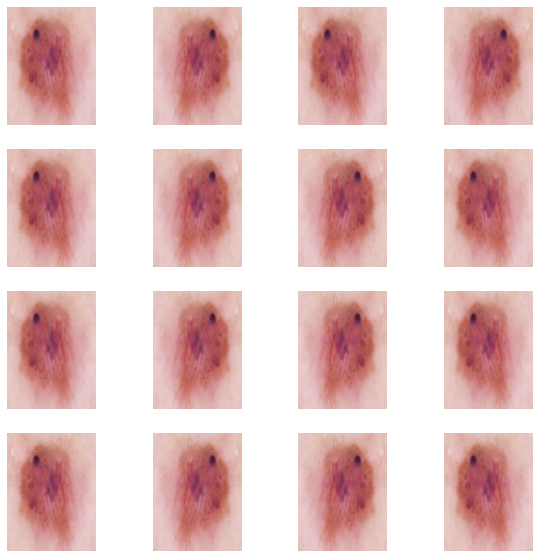

In [10]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    # preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    # preprocessing.RandomRotation(factor=0.20),
    # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

# NN

## NN creation

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.InputLayer(input_shape=[600, 450, 3]),
    
    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(7, activation='softmax'),
])

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 600, 450, 3)       21        
_________________________________________________________________
conv2d (Conv2D)              (None, 600, 450, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 300, 225, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 225, 32)      224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 225, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 112, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 112, 32)     

In [12]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=1,
    use_multiprocessing=True,
)

126/126 [==============================] - 1176s 9s/step - loss: 1.3283 - categorical_accuracy: 0.6284 - val_loss: 1.2876 - val_categorical_accuracy: 0.6523


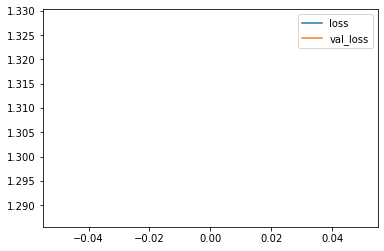

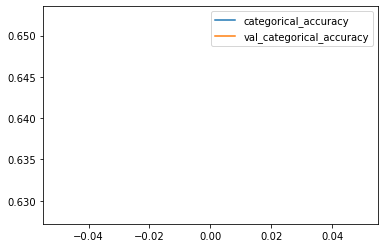

In [13]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

In [14]:
predictions = np.array([])
labels =  np.array([])
for x, y in ds_train:
  predictions = np.concatenate([predictions, model.predict_classes(x)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

confusion_matrix(y_true=labels, y_pred=predictions)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[   9,   35,   14,    2,    2,   54,    6],
       [  31,   42,   35,    1,   11,   83,    7],
       [   5,  116,   47,    0,   16,  240,    5],
       [   6,    9,    8,    0,    2,   22,    3],
       [   2,   34,   16,    0,    8,  400,    3],
       [  20,  105,   41,    1,   26, 2489,    3],
       [   2,    1,    0,    0,    1,   43,    1]], dtype=int64)

In [15]:
df = pd.DataFrame(tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy(),
             columns = label_encoding,
             index = label_encoding,)
df / df.sum()

,akiec,bcc,bkl,df,mel,nv,vasc
akiec,0.120000,0.102339,0.086957,0.50,0.030303,0.016211,0.214286
bcc,0.413333,0.122807,0.217391,0.25,0.166667,0.024917,0.250000
bkl,0.066667,0.339181,0.291925,0.00,0.242424,0.072050,0.178571
df,0.080000,0.026316,0.049689,0.00,0.030303,0.006605,0.107143
mel,0.026667,0.099415,0.099379,0.00,0.121212,0.120084,0.107143
nv,0.266667,0.307018,0.254658,0.25,0.393939,0.747223,0.107143
vasc,0.026667,0.002924,0.000000,0.00,0.015152,0.012909,0.035714


In [16]:
predictions = np.array([])
labels =  np.array([])
for x, y in ds_train:
  predictions = np.concatenate([predictions, model.predict_classes(x)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[   9,   35,   14,    2,    2,   54,    6],
       [  31,   42,   35,    1,   11,   83,    7],
       [   5,  116,   47,    0,   16,  240,    5],
       [   6,    9,    8,    0,    2,   22,    3],
       [   2,   34,   16,    0,    8,  400,    3],
       [  20,  105,   41,    1,   26, 2489,    3],
       [   2,    1,    0,    0,    1,   43,    1]])

<AxesSubplot:>

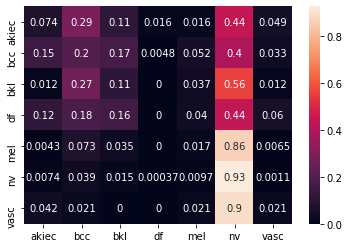

In [17]:
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predictions, normalize = 'true'),
             columns = label_encoding,
             index = label_encoding,)
sns.heatmap(df, annot = True)

In [18]:
model2 = keras.Sequential([
    layers.InputLayer(input_shape=[600, 450, 3]),
    
    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(7, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 600, 450, 3)       21        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 600, 450, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 300, 225, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 300, 225, 32)      224       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 300, 225, 32)      25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 150, 112, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 150, 112, 32)     

In [19]:
class_weights = {
    0 : 1,
    1 : 1,
    2 : 1,
    3 : 1,
    4 : 5,
    5 : 1,
    6 : 1,
}

In [20]:
history = model2.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=1,
    use_multiprocessing=True,
    class_weight = class_weights
)

126/126 [==============================] - 1145s 9s/step - loss: 2.1664 - categorical_accuracy: 0.5465 - val_loss: 1.3932 - val_categorical_accuracy: 0.2997


In [21]:
predictions = np.array([])
labels =  np.array([])
for x, y in ds_train:
  predictions = np.concatenate([predictions, model2.predict_classes(x)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

confusion_matrix(y_true=labels, y_pred=predictions)

array([[   5,    8,    1,    0,   11,   94,    3],
       [   3,   16,    6,    0,   29,  145,   11],
       [   4,    6,    2,    0,  217,  189,   11],
       [   1,    8,    1,    0,    8,   30,    2],
       [   1,    0,    0,    0,  315,  147,    0],
       [   1,    8,    3,    0, 1751,  916,    6],
       [   1,    0,    0,    0,    6,   38,    3]], dtype=int64)

<AxesSubplot:>

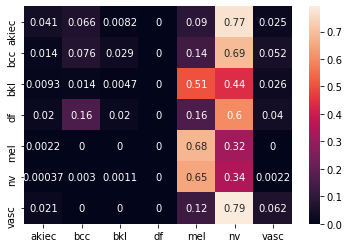

In [22]:
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predictions, normalize = 'true'),
             columns = label_encoding,
             index = label_encoding,)
sns.heatmap(df, annot = True)

# NN visualisation to better understand NN built and how we can imrpove it

In [23]:
layer_names = [layer.name for layer in model.layers]
layer_names

['batch_normalization',
 'conv2d',
 'max_pooling2d',
 'batch_normalization_1',
 'conv2d_1',
 'max_pooling2d_1',
 'batch_normalization_2',
 'conv2d_2',
 'max_pooling2d_2',
 'batch_normalization_3',
 'conv2d_3',
 'max_pooling2d_3',
 'batch_normalization_4',
 'flatten',
 'dense',
 'dense_1']

In [24]:
model.layers

In [25]:
feature_map_model = tf.keras.Model(model.inputs, layer_outputs)

NameError: name 'layer_outputs' is not defined

In [ ]:
image_path= r"C:\Users\singl\studies\AML\Project\HAM10000Classification\data\all_images\ISIC_0024306.jpg" 
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(600, 450, 3))  
input = tf.keras.preprocessing.image.img_to_array(img)                        
# input = input.reshape((1,) + input.shape)                   
# input /= 255.0

In [ ]:
input.shape

In [26]:
feature_maps = feature_map_model.predict(ds_valid)

NameError: name 'feature_map_model' is not defined

In [230]:
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

NameError: name 'filters' is not defined

In [241]:
import tensorflow as tf
from matplotlib import pyplot as plt

#Visualizes convolutional layer activations
def visualize_activations(model, validation_iterator):

  #A keras model that will output our previous model's activations for each convolutional layer:
  activation_extractor = tf.keras.Model(inputs=model.inputs, 
                                        outputs=[layer.output for layer in model.layers if "conv2d" in layer.name])

  #Take matplotlib frame and remove axes.
  def clean_plot(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)

  #Dict mapping from class numbers to string labels:
  class_names = {0:"Regular",1:"Ringed",2:"Merger",3:"Other"}

  #Loads a sample batch of data
  sample_batch_input,sample_labels = validation_iterator.take(1)
 
  #Grabs the first five images
  sample_batch_input = sample_batch_input[:5]
  sample_labels = sample_labels[:5]

  #Makes predictions using model.predict(x)
  sample_predictions = model.predict(sample_batch_input)

  #Iterate of images, predictions, and true labels
  for i,(image, prediction, label) in enumerate(zip(sample_batch_input, sample_predictions, sample_labels)):

    image_name = "Galaxy_{}".format(i)

    #Gets predicted class with highest probability

    predicted_class = tf.argmax(prediction).numpy()

    #Gets correct label
    actual_class = tf.argmax(label).numpy()

    print(image_name)
    print("\tModel prediction: {}".format(prediction))
    print("\tTrue label: {} ({})".format(class_names[actual_class], actual_class))
    print("\tCorrect:", predicted_class == actual_class)

    #Saves image file using matplotlib
    sample_image = image
    clean_plot(plt.imshow(sample_image))

    plt.title(image_name+" Predicted: {}, Actual: {}".format(class_names[predicted_class], class_names[actual_class]))
    plt.savefig('static/images/'+image_name+".png")
    model_layer_output = activation_extractor(tf.expand_dims(sample_image,0))
    
    plt.clf()

    #Iterates over each layer output
    for l_num,output_data in enumerate(model_layer_output):

      #Creates a subplot for each filter
      fig, axs = plt.subplots(1, output_data.shape[-1])
      
      #For each filter
      for i in range(output_data.shape[-1]):

        #Plots the filter's activations
        
        clean_plot(axs[i].imshow(output_data[0][:, :, i], cmap="gray"))
      plt.suptitle(image_name+" Conv {}".format(l_num),y=0.6)
      plt.savefig('static/images/' + image_name+ "Conv{}.png".format(l_num))
      plt.clf()

In [242]:
visualize_activations(model,ds_train)

ValueError: not enough values to unpack (expected 2, got 1)

In [237]:
for images, label in ds_train

<PrefetchDataset shapes: ((None, 600, 450, 3), (None, 7)), types: (tf.float32, tf.float32)>